**Assignment 15: Train a fruit quality detector - 10422030**

**Question:** In this lesson you trained an image classifier to be able to distinguish between ripe and unripe fruits, but only using one type of fruit. A classifier can be trained to recognize multiple fruits, with varying rates of success depending on the type of fruit and the difference between ripe and unripe.

For example, with fruits that change color when they ripen, image classifiers might be less effective than a color sensor as they usually work on grey scale images instead of full color.

Train your classifier with other fruits to see how well it works, especially when fruits look similar. For example, apples and tomatoes.

***- In this assignment, I will using Google Colab to train and detect data. The data I choose is "Tomato".***

The project involved collecting images, preparing corresponding labels, building and training a convolutional neural network (CNN), and evaluating its performance. Finally, I tested the trained model on individual images to observe prediction quality.

**I. Train and test the model to detect Tomato**

**Step 1: Connect to Google Drive and Prepare the library**

In [7]:
#Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
# Set your dataset paths
image_dir = '/content/drive/MyDrive/Tomato/Images'
label_dir = '/content/drive/MyDrive/Tomato/labels'

In [31]:
# import library
import pandas as pd
import tensorflow as tf
import os
import matplotlib.pyplot as plt

In [32]:
# check GPU
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


**Step 2: Collect image paths and labels**

In [33]:
# Collect image paths and labels

image_files = sorted([f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

file_paths = []
labels = []

for img_file in image_files:
    img_path = os.path.join(image_dir, img_file)
    label_file = os.path.join(label_dir, os.path.splitext(img_file)[0] + '.txt')

    if os.path.exists(label_file):
        with open(label_file, 'r') as f:
            # Assume first line has class index (or extract appropriately)
            line = f.readline().strip()
            class_id = int(line.split()[0])  # If YOLO: first number is class index
        file_paths.append(img_path)
        labels.append(class_id)
    else:
        print(f"Warning: Label file not found for {img_file}")

print(f"Collected {len(file_paths)} image-label pairs.")

Collected 177 image-label pairs.


**Step 3: Prepare TensorFlow Dataset**

In [34]:
# Prepare TensorFlow Dataset

import tensorflow as tf

img_size = (180, 180)
batch_size = 32
num_classes = len(set(labels))
print(f"Detected {num_classes} unique classes.")

def process_path(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, img_size)
    img = img / 255.0
    return img, label

path_ds = tf.data.Dataset.from_tensor_slices((file_paths, labels))
image_label_ds = path_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

dataset = image_label_ds.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)


Detected 2 unique classes.


**Step 4: Split into train and validation sets**

In [35]:
# Split into train and validation sets

total_size = len(file_paths)
train_size = int(0.8 * total_size)

train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size)

**Step 5: Define CNN Model**

In [36]:
# Define CNN Model

from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,647,234 (25.36 MB)

 Trainable params: 6,647,234 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

**Step 6: Train the model**

In [37]:
# Train the model

epochs = 15

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.5013 - loss: 1.4080  
Epoch 2/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


6/6 ━━━━━━━━━━━━━━━━━━━━ 39s 979ms/step - accuracy: 0.6555 - loss: 0.5757
Epoch 3/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 727ms/step - accuracy: 0.7809 - loss: 0.3522
Epoch 4/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 914ms/step - accuracy: 0.8895 - loss: 0.3177
Epoch 5/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9320 - loss: 0.3018 
Epoch 6/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 717ms/step - accuracy: 0.9103 - loss: 0.2269
Epoch 7/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 860ms/step - accuracy: 0.9315 - loss: 0.1570
Epoch 8/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 711ms/step - accuracy: 0.9611 - loss: 0.1002
Epoch 9/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 799ms/step - accuracy: 0.9349 - loss: 0.1794
Epoch 10/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9644 - loss: 0.0993 
Epoch 11/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 735ms/step - accuracy: 0.9523 - loss: 0.1641
Epoch 12/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 736ms/step - accuracy: 0.9572 - loss: 0.1079
Epoch 13/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 994ms/step - accuracy: 0.9779 - loss: 0.0808

**Stept 7: Plot the result**

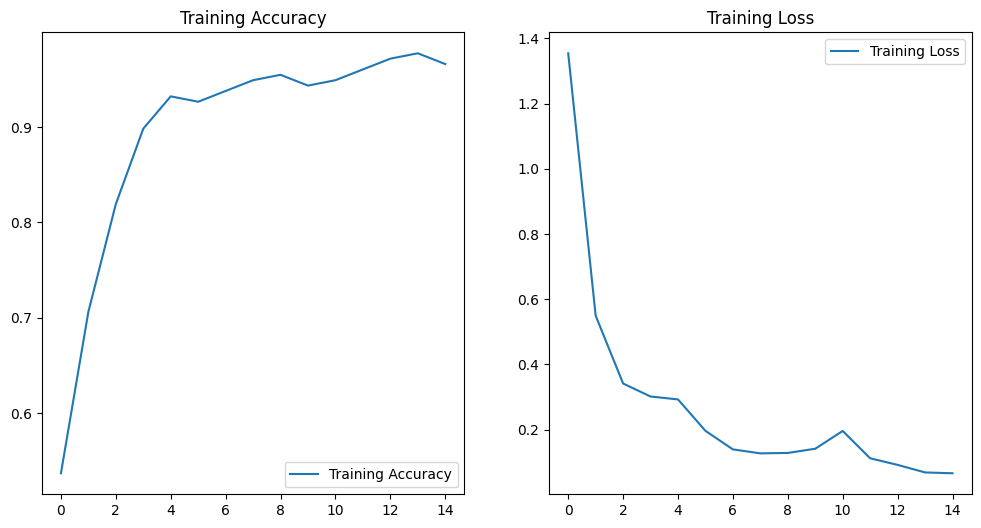

In [39]:
# Plot training results

acc = history.history['accuracy']
loss = history.history['loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')

plt.show()


**Step 8: Save the model**

In [40]:
# Save the trained model

model.save('/content/drive/MyDrive/Tomato/Result/tomato_fruits_trained_model.h5')
print("Model saved to Google Drive!")

Model saved to Google Drive!


**Step 9: Load Model and test**

In [51]:
# Load the model
import tensorflow as tf

model = tf.keras.models.load_model('/content/drive/MyDrive/Tomato/Result/tomato_fruits_trained_model.h5')
print("Model loaded successfully!")

Model loaded successfully!


In [52]:
# check the model

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,647,236 (25.36 MB)

 Trainable params: 6,647,234 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [65]:
# pick random 1 image to test

import random
import os

image_folder = '/content/drive/MyDrive/Tomato/Images'
image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

random_image = random.choice(image_files)
image_path = os.path.join(image_folder, random_image)

print(f"Selected image: {image_path}")


Selected image: /content/drive/MyDrive/Tomato/Images/unriped_tomato_4.jpeg


In [66]:
# Preprocess the image

from tensorflow.keras.preprocessing import image
import numpy as np

img_size = (180, 180)  # ← change to match your model input size, see in model sumary()

img = image.load_img(image_path, target_size=img_size)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Normalize if needed

print("Image preprocessed.")

Image preprocessed.


In [67]:
# Predict
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)[0]

class_names = ['unripe_tomato', 'ripe_tomato', 'unripe_banana', 'ripe_banana']

print(f"Predicted class index: {predicted_class}")
print(f"Predicted class name: {class_names[predicted_class]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted class index: 0
Predicted class name: unripe_tomato


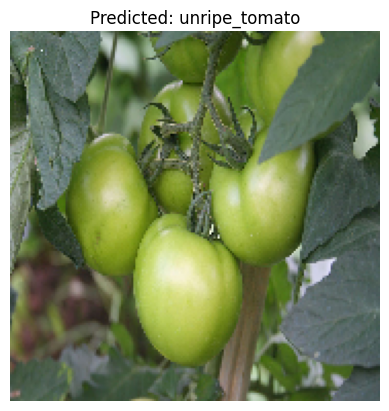

In [68]:
# Display the image

import matplotlib.pyplot as plt

plt.imshow(img)
plt.title(f"Predicted: {class_names[predicted_class]}")
plt.axis('off')
plt.show()

**II. Conclusion**

I successfully trained an image classifier to distinguish between ripe and unripe fruits across multiple fruit types. The CNN generalized well, though certain fruits with similar colors challenged the classifier’s accuracy.